In [1]:
#doing things with data
import pandas as pd
import itertools
import numpy as np
import scipy.stats as stats
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import TweedieRegressor

#import r2
from sklearn.metrics import r2_score

import env
import acquire as a
import wrangle as w
import explore as e
import prepare as p
import evaluate as eva

import warnings
warnings.filterwarnings("ignore")

# Acquire
- Performed initial exploratory analysis to ensure required colums were brought in from SQL
- Wrote necessary function to pull data from SQL using embedded ENV/Acquire.py files (repeatable)
- There is a CSV now with the requisite rows, for quicker future access

In [2]:
# get data
df = a.get_zillow2()
df

csv file found and loaded


,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City
0,223700.0,1733.0,6037.0,3.0,3.0,7340.0,1990.0,NaN,97328.0,40227.0
1,390328.0,1319.0,6037.0,3.0,2.0,8618.0,1956.0,NaN,96523.0,14542.0
2,1697653.0,2535.0,6037.0,3.0,4.0,8497.0,1949.0,NaN,96109.0,29712.0
3,613876.0,2470.0,6037.0,4.0,3.0,8497.0,1989.0,NaN,96415.0,12447.0
4,985000.0,1589.0,6037.0,3.0,2.0,6995.0,1947.0,NaN,96424.0,12447.0
...,...,...,...,...,...,...,...,...,...,...
52436,455588.0,868.0,6037.0,3.0,1.0,6501.0,1952.0,NaN,96163.0,54722.0
52437,731898.0,2638.0,6111.0,4.0,2.5,14436.0,1970.0,1.0,96384.0,41673.0
52438,1300000.0,4280.0,6059.0,5.0,5.5,8269.0,2005.0,1.0,96985.0,33840.0
52439,671000.0,2675.0,6037.0,3.0,3.0,18274.0,1962.0,NaN,96370.0,12447.0


In [3]:
#take a look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52441 entries, 0 to 52440
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Tax_Value   52440 non-null  float64
 1   Sqft        52359 non-null  float64
 2   County      52441 non-null  float64
 3   Bedrooms    52441 non-null  float64
 4   Bathrooms   52441 non-null  float64
 5   Lot_Size    52072 non-null  float64
 6   Year_Built  52325 non-null  float64
 7   Pool        11096 non-null  float64
 8   Zip_Code    52415 non-null  float64
 9   City        51404 non-null  float64
dtypes: float64(10)
memory usage: 4.4 MB


# Prepare
- Checked for nulls
    - Set Pool value nulls to 0 (for no pool). The data matches the average of homes in Southern California with pools.  
    - Drop nulls, there are only 568 null values which is .01% of the data. 
    - Dropping them will not have a major impact on the result of the study.
- Encode values for machine learning
- Handle outliers
    - Tax_Value less than 2 million
    - Sqft less than 7250 
    - Bedrooms less than 8
    - Bathrooms less than 5
- Create dummy variable for County location
- Create Wrangle file
- Create Train, Validate, and Test (60%, 20%, 20% : respectively)
- Create scaled data set (to use in modeling phase)

In [4]:
#Check for nulls/missing values
df.isnull().sum()

Tax_Value         1
Sqft             82
County            0
Bedrooms          0
Bathrooms         0
Lot_Size        369
Year_Built      116
Pool          41345
Zip_Code         26
City           1037
dtype: int64

In [5]:
#look at pool values
df.Pool.value_counts()

1.0    11096
Name: Pool, dtype: int64

In [6]:
# The national average is 8% of homes have pools and southern California is 19%. I will fill na with 0 as (no pool)
11096/52411

0.21171128198278988

In [7]:
# fill in null pool values with 0 to identify those houses not having a pool
df.Pool = df.Pool.fillna(0)
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City
0,223700.0,1733.0,6037.0,3.0,3.0,7340.0,1990.0,0.0,97328.0,40227.0
1,390328.0,1319.0,6037.0,3.0,2.0,8618.0,1956.0,0.0,96523.0,14542.0
2,1697653.0,2535.0,6037.0,3.0,4.0,8497.0,1949.0,0.0,96109.0,29712.0
3,613876.0,2470.0,6037.0,4.0,3.0,8497.0,1989.0,0.0,96415.0,12447.0
4,985000.0,1589.0,6037.0,3.0,2.0,6995.0,1947.0,0.0,96424.0,12447.0
...,...,...,...,...,...,...,...,...,...,...
52436,455588.0,868.0,6037.0,3.0,1.0,6501.0,1952.0,0.0,96163.0,54722.0
52437,731898.0,2638.0,6111.0,4.0,2.5,14436.0,1970.0,1.0,96384.0,41673.0
52438,1300000.0,4280.0,6059.0,5.0,5.5,8269.0,2005.0,1.0,96985.0,33840.0
52439,671000.0,2675.0,6037.0,3.0,3.0,18274.0,1962.0,0.0,96370.0,12447.0


In [8]:
# verify pool changes have been made
df.isnull().sum()

Tax_Value        1
Sqft            82
County           0
Bedrooms         0
Bathrooms        0
Lot_Size       369
Year_Built     116
Pool             0
Zip_Code        26
City          1037
dtype: int64

In [9]:
# Drop nulls, there are only 568 null values which is .01% of the data. 
# Dropping them will not have a major impact on the result of the study.
df = df.dropna()
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City
0,223700.0,1733.0,6037.0,3.0,3.0,7340.0,1990.0,0.0,97328.0,40227.0
1,390328.0,1319.0,6037.0,3.0,2.0,8618.0,1956.0,0.0,96523.0,14542.0
2,1697653.0,2535.0,6037.0,3.0,4.0,8497.0,1949.0,0.0,96109.0,29712.0
3,613876.0,2470.0,6037.0,4.0,3.0,8497.0,1989.0,0.0,96415.0,12447.0
4,985000.0,1589.0,6037.0,3.0,2.0,6995.0,1947.0,0.0,96424.0,12447.0
...,...,...,...,...,...,...,...,...,...,...
52436,455588.0,868.0,6037.0,3.0,1.0,6501.0,1952.0,0.0,96163.0,54722.0
52437,731898.0,2638.0,6111.0,4.0,2.5,14436.0,1970.0,1.0,96384.0,41673.0
52438,1300000.0,4280.0,6059.0,5.0,5.5,8269.0,2005.0,1.0,96985.0,33840.0
52439,671000.0,2675.0,6037.0,3.0,3.0,18274.0,1962.0,0.0,96370.0,12447.0


In [10]:
#Change County code to actual county
df['County'] = df['County'].replace([6037.0, 6059.0, 6111.0],['LA','Orange','Ventura']).astype(str)
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City
0,223700.0,1733.0,LA,3.0,3.0,7340.0,1990.0,0.0,97328.0,40227.0
1,390328.0,1319.0,LA,3.0,2.0,8618.0,1956.0,0.0,96523.0,14542.0
2,1697653.0,2535.0,LA,3.0,4.0,8497.0,1949.0,0.0,96109.0,29712.0
3,613876.0,2470.0,LA,4.0,3.0,8497.0,1989.0,0.0,96415.0,12447.0
4,985000.0,1589.0,LA,3.0,2.0,6995.0,1947.0,0.0,96424.0,12447.0
...,...,...,...,...,...,...,...,...,...,...
52436,455588.0,868.0,LA,3.0,1.0,6501.0,1952.0,0.0,96163.0,54722.0
52437,731898.0,2638.0,Ventura,4.0,2.5,14436.0,1970.0,1.0,96384.0,41673.0
52438,1300000.0,4280.0,Orange,5.0,5.5,8269.0,2005.0,1.0,96985.0,33840.0
52439,671000.0,2675.0,LA,3.0,3.0,18274.0,1962.0,0.0,96370.0,12447.0


In [11]:
#Encode values for machine learning
dummy_df = pd.get_dummies(df['County'], drop_first=False)
df = pd.concat([df, dummy_df], axis=1)
df

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City,LA,Orange,Ventura
0,223700.0,1733.0,LA,3.0,3.0,7340.0,1990.0,0.0,97328.0,40227.0,1,0,0
1,390328.0,1319.0,LA,3.0,2.0,8618.0,1956.0,0.0,96523.0,14542.0,1,0,0
2,1697653.0,2535.0,LA,3.0,4.0,8497.0,1949.0,0.0,96109.0,29712.0,1,0,0
3,613876.0,2470.0,LA,4.0,3.0,8497.0,1989.0,0.0,96415.0,12447.0,1,0,0
4,985000.0,1589.0,LA,3.0,2.0,6995.0,1947.0,0.0,96424.0,12447.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52436,455588.0,868.0,LA,3.0,1.0,6501.0,1952.0,0.0,96163.0,54722.0,1,0,0
52437,731898.0,2638.0,Ventura,4.0,2.5,14436.0,1970.0,1.0,96384.0,41673.0,0,0,1
52438,1300000.0,4280.0,Orange,5.0,5.5,8269.0,2005.0,1.0,96985.0,33840.0,0,1,0
52439,671000.0,2675.0,LA,3.0,3.0,18274.0,1962.0,0.0,96370.0,12447.0,1,0,0


# Handle outliers

### Outlier in Tax_Value

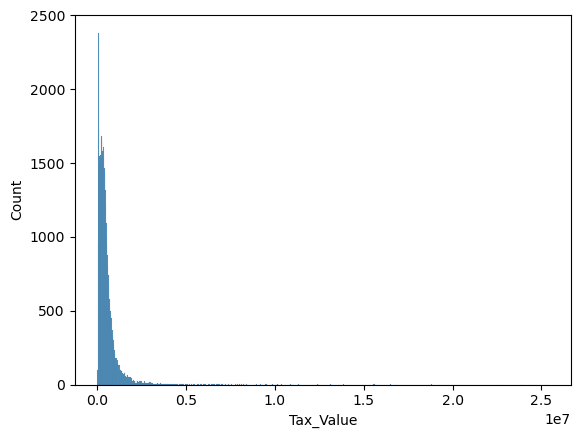

In [12]:
# Tax_Value histogram before outlier removal
sns.histplot(df.Tax_Value)
plt.show()

In [13]:
# Tax_Value less than 2 million
df = df[df.Tax_Value <= 2000000]

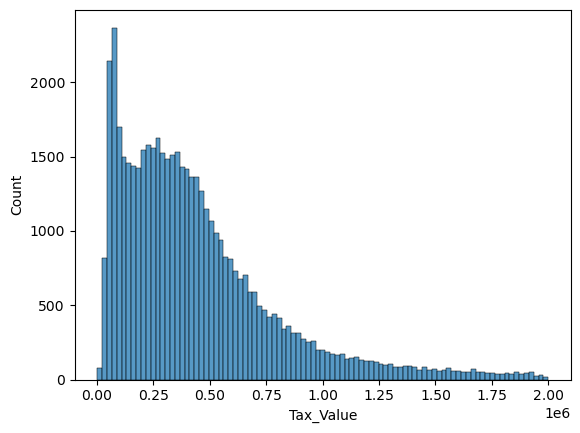

In [14]:
# Tax_Value histogram after outlier removal
sns.histplot(df.Tax_Value)
plt.show()

#### Outliers in Sqft

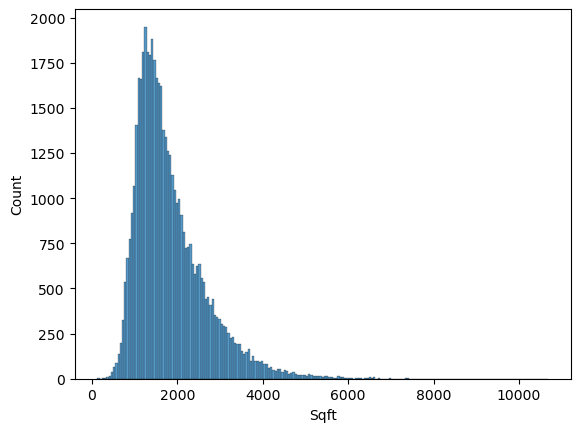

In [15]:
# Tax_Value histogram before outlier removal
sns.histplot(df.Sqft)
plt.show()

In [16]:
# Sqft less than 6000 
df = df[df.Sqft <= 6000]

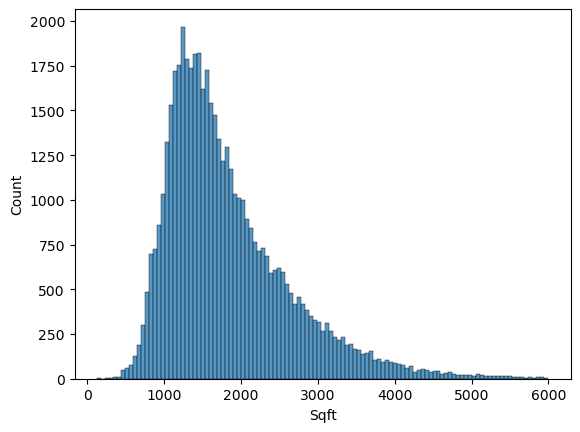

In [17]:
# Tax_Value histogram after outlier removal
sns.histplot(df.Sqft)
plt.show()

#### Outliers in Bedrooms


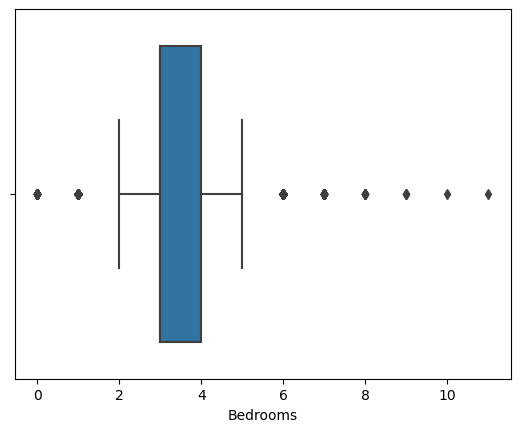

In [18]:
#Bedrooms before outlier removal
sns.boxplot(df.Bedrooms)
plt.show()

In [19]:
# Bedrooms less than 8
df = df[df.Bedrooms <= 8]

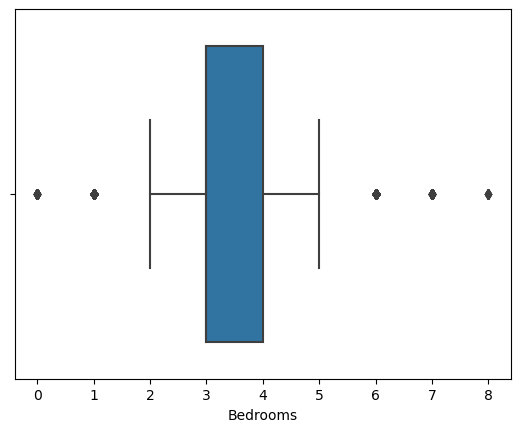

In [20]:
#Bedrooms after outlier removal
sns.boxplot(df.Bedrooms)
plt.show()

#### Outliers in Bathrooms

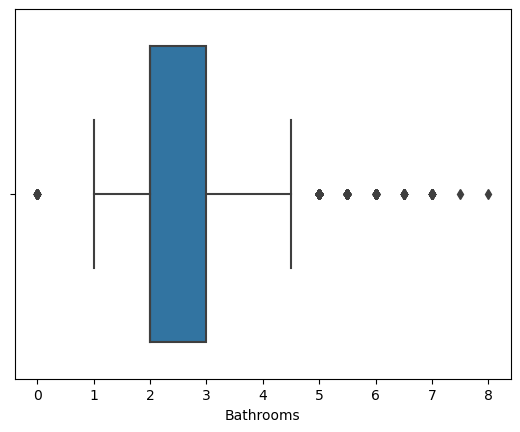

In [21]:
#Bathroom before outlier removal
sns.boxplot(df.Bathrooms)
plt.show()

In [22]:
# Bathrooms less than 5
df = df[df.Bathrooms <= 5]

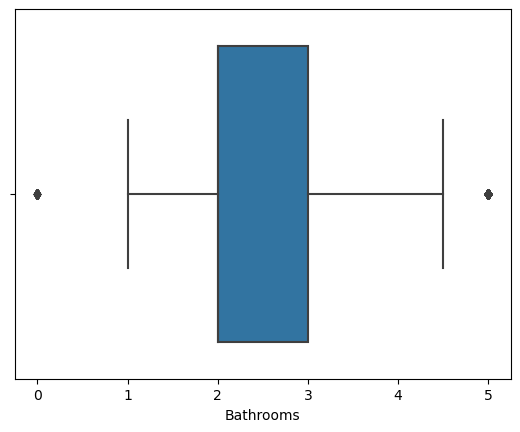

In [23]:
#Bathroom after outlier removal
sns.boxplot(df.Bathrooms)
plt.show()

### Outliers in Lot_Size

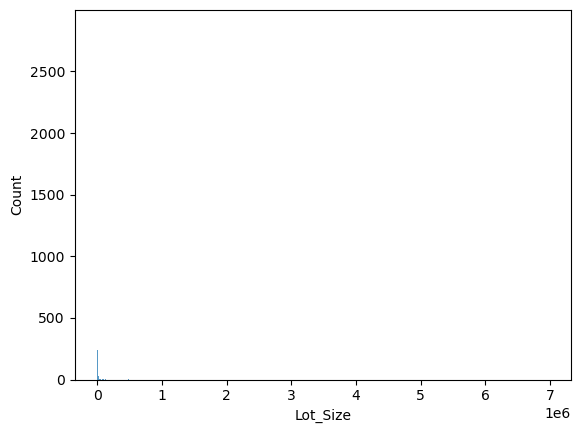

In [24]:
# Lot_Size histogram before outlier removal
sns.histplot(df.Lot_Size)
plt.show()

In [25]:
# Lot_Size greater than 12000
df = df[df.Lot_Size <= 20000]

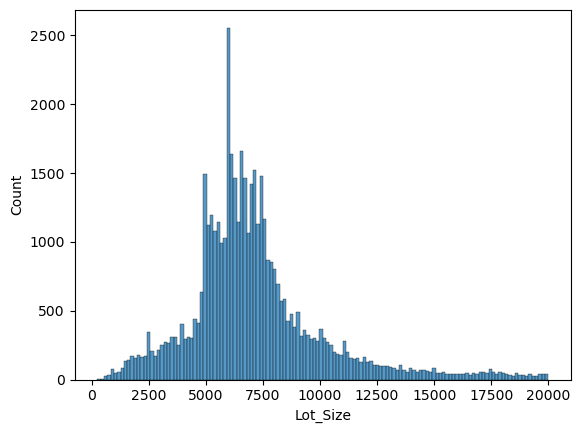

In [26]:
# Lot_Size histogram before outlier removal
sns.histplot(df.Lot_Size)
plt.show()

### Outliers in Year_Built

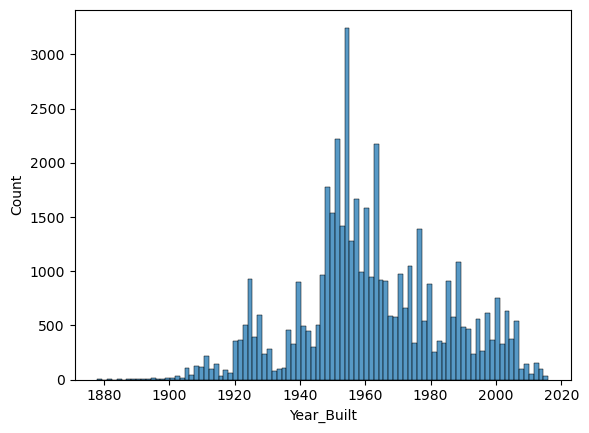

In [27]:
# Year_built histogram before outlier removal
sns.histplot(df.Year_Built)
plt.show()

In [28]:
# Year_Built greater than 1920
df = df[df.Year_Built >= 1920]

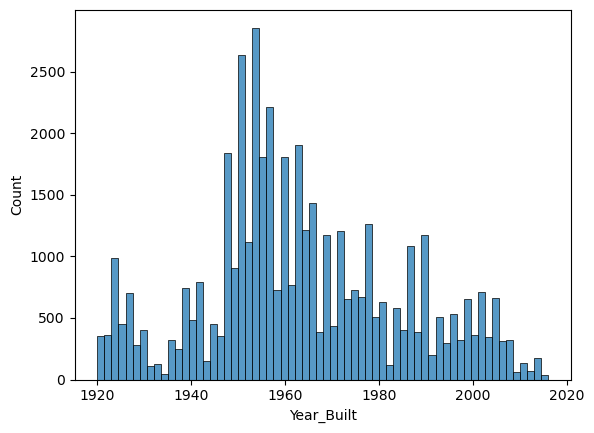

In [29]:
# Year_Built histogram after outlier removal
sns.histplot(df.Year_Built)
plt.show()

In [31]:
# After removal of outliers, there have been 6,685 houses removed. That is 13% of the data. 
df.shape

(45726, 13)

# Create Wrangle.py and test

In [32]:
# Call wrangle file with changes made from above from .py
df = w.wrangle_zillow2()
df

csv file found and loaded


,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City,LA,Orange,Ventura
0,223700.0,1733.0,LA,3.0,3.0,7340.0,1990.0,0.0,97328.0,40227.0,1,0,0
1,390328.0,1319.0,LA,3.0,2.0,8618.0,1956.0,0.0,96523.0,14542.0,1,0,0
2,1697653.0,2535.0,LA,3.0,4.0,8497.0,1949.0,0.0,96109.0,29712.0,1,0,0
3,613876.0,2470.0,LA,4.0,3.0,8497.0,1989.0,0.0,96415.0,12447.0,1,0,0
4,985000.0,1589.0,LA,3.0,2.0,6995.0,1947.0,0.0,96424.0,12447.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52432,510076.0,2302.0,LA,3.0,3.0,4425.0,1995.0,0.0,96282.0,12447.0,1,0,0
52433,70811.0,1598.0,LA,3.0,2.0,9553.0,1964.0,0.0,96337.0,37688.0,1,0,0
52434,336932.0,1696.0,LA,3.0,2.0,7615.0,1978.0,0.0,96282.0,12447.0,1,0,0
52436,455588.0,868.0,LA,3.0,1.0,6501.0,1952.0,0.0,96163.0,54722.0,1,0,0


## create train(60%), validate(20%) and test(20%) data set

In [33]:
## create train(60%), validate(20%) and test(20%) data set
train, validate, test = p.split_data(df)
train

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City,LA,Orange,Ventura
15678,515074.0,1618.0,Orange,4.0,2.0,8500.0,1975.0,0.0,97063.0,33252.0,0,1,0
37721,858193.0,1881.0,Orange,3.0,2.5,1457.0,1964.0,0.0,96978.0,53571.0,0,1,0
22305,103394.0,1437.0,LA,4.0,2.0,8924.0,1955.0,0.0,96524.0,14542.0,1,0,0
36063,131261.0,2465.0,LA,4.0,3.0,7692.0,1966.0,0.0,96356.0,12447.0,1,0,0
1838,643884.0,1526.0,Orange,3.0,2.0,6025.0,1962.0,0.0,96967.0,25218.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
41765,107447.0,2030.0,Orange,2.0,2.0,5200.0,1983.0,0.0,96954.0,52650.0,0,1,0
27898,88384.0,1370.0,LA,2.0,2.0,10849.0,1959.0,0.0,96496.0,6021.0,1,0,0
29550,403872.0,1289.0,LA,3.0,2.0,5507.0,1944.0,0.0,96021.0,272578.0,1,0,0
32698,282568.0,1362.0,LA,3.0,2.0,7494.0,1939.0,0.0,96514.0,33837.0,1,0,0


## Create scaled data set for modeling

In [34]:
# Create scaled data for modeling using MinMax scaler
X_train_scaled, X_validate_scaled, X_test_scaled, y_train, y_validate, y_test = p.scaled_df2(train, validate, test)
X_train_scaled

,Sqft,Bedrooms,Bathrooms,Year_Built,Pool
15678,0.258508,0.500,0.4,0.572917,0.0
37721,0.304885,0.375,0.5,0.458333,0.0
22305,0.226591,0.500,0.4,0.364583,0.0
36063,0.407865,0.500,0.6,0.479167,0.0
1838,0.242285,0.375,0.4,0.437500,0.0
...,...,...,...,...,...
41765,0.331159,0.250,0.4,0.656250,0.0
27898,0.214777,0.250,0.4,0.406250,0.0
29550,0.200494,0.375,0.4,0.250000,0.0
32698,0.213366,0.375,0.4,0.197917,0.0


# Explore

**Target = Tax_Value***
- Perform EDA on train data set only
    - How does Sqft affect Tax_Value?
    - How does Bedrooms affect Tax_Value?
    - How does Bathrooms affect Tax_Value?
    - How does Lot_Size affect Tax_Value?
    - How does Year_Built affect Tax_Value?
    - How does having a Pool affect Tax_Value?
    - Does location affect Tax_Value? Which location is the most expensive? The cheapest?
- Visualize relationships
- Confirm relationships with statistical testing
- Use Kbest and/or RFE (recursive feature elimination)

In [35]:
# look at train
train.head()

,Tax_Value,Sqft,County,Bedrooms,Bathrooms,Lot_Size,Year_Built,Pool,Zip_Code,City,LA,Orange,Ventura
15678,515074.0,1618.0,Orange,4.0,2.0,8500.0,1975.0,0.0,97063.0,33252.0,0,1,0
37721,858193.0,1881.0,Orange,3.0,2.5,1457.0,1964.0,0.0,96978.0,53571.0,0,1,0
22305,103394.0,1437.0,LA,4.0,2.0,8924.0,1955.0,0.0,96524.0,14542.0,1,0,0
36063,131261.0,2465.0,LA,4.0,3.0,7692.0,1966.0,0.0,96356.0,12447.0,1,0,0
1838,643884.0,1526.0,Orange,3.0,2.0,6025.0,1962.0,0.0,96967.0,25218.0,0,1,0


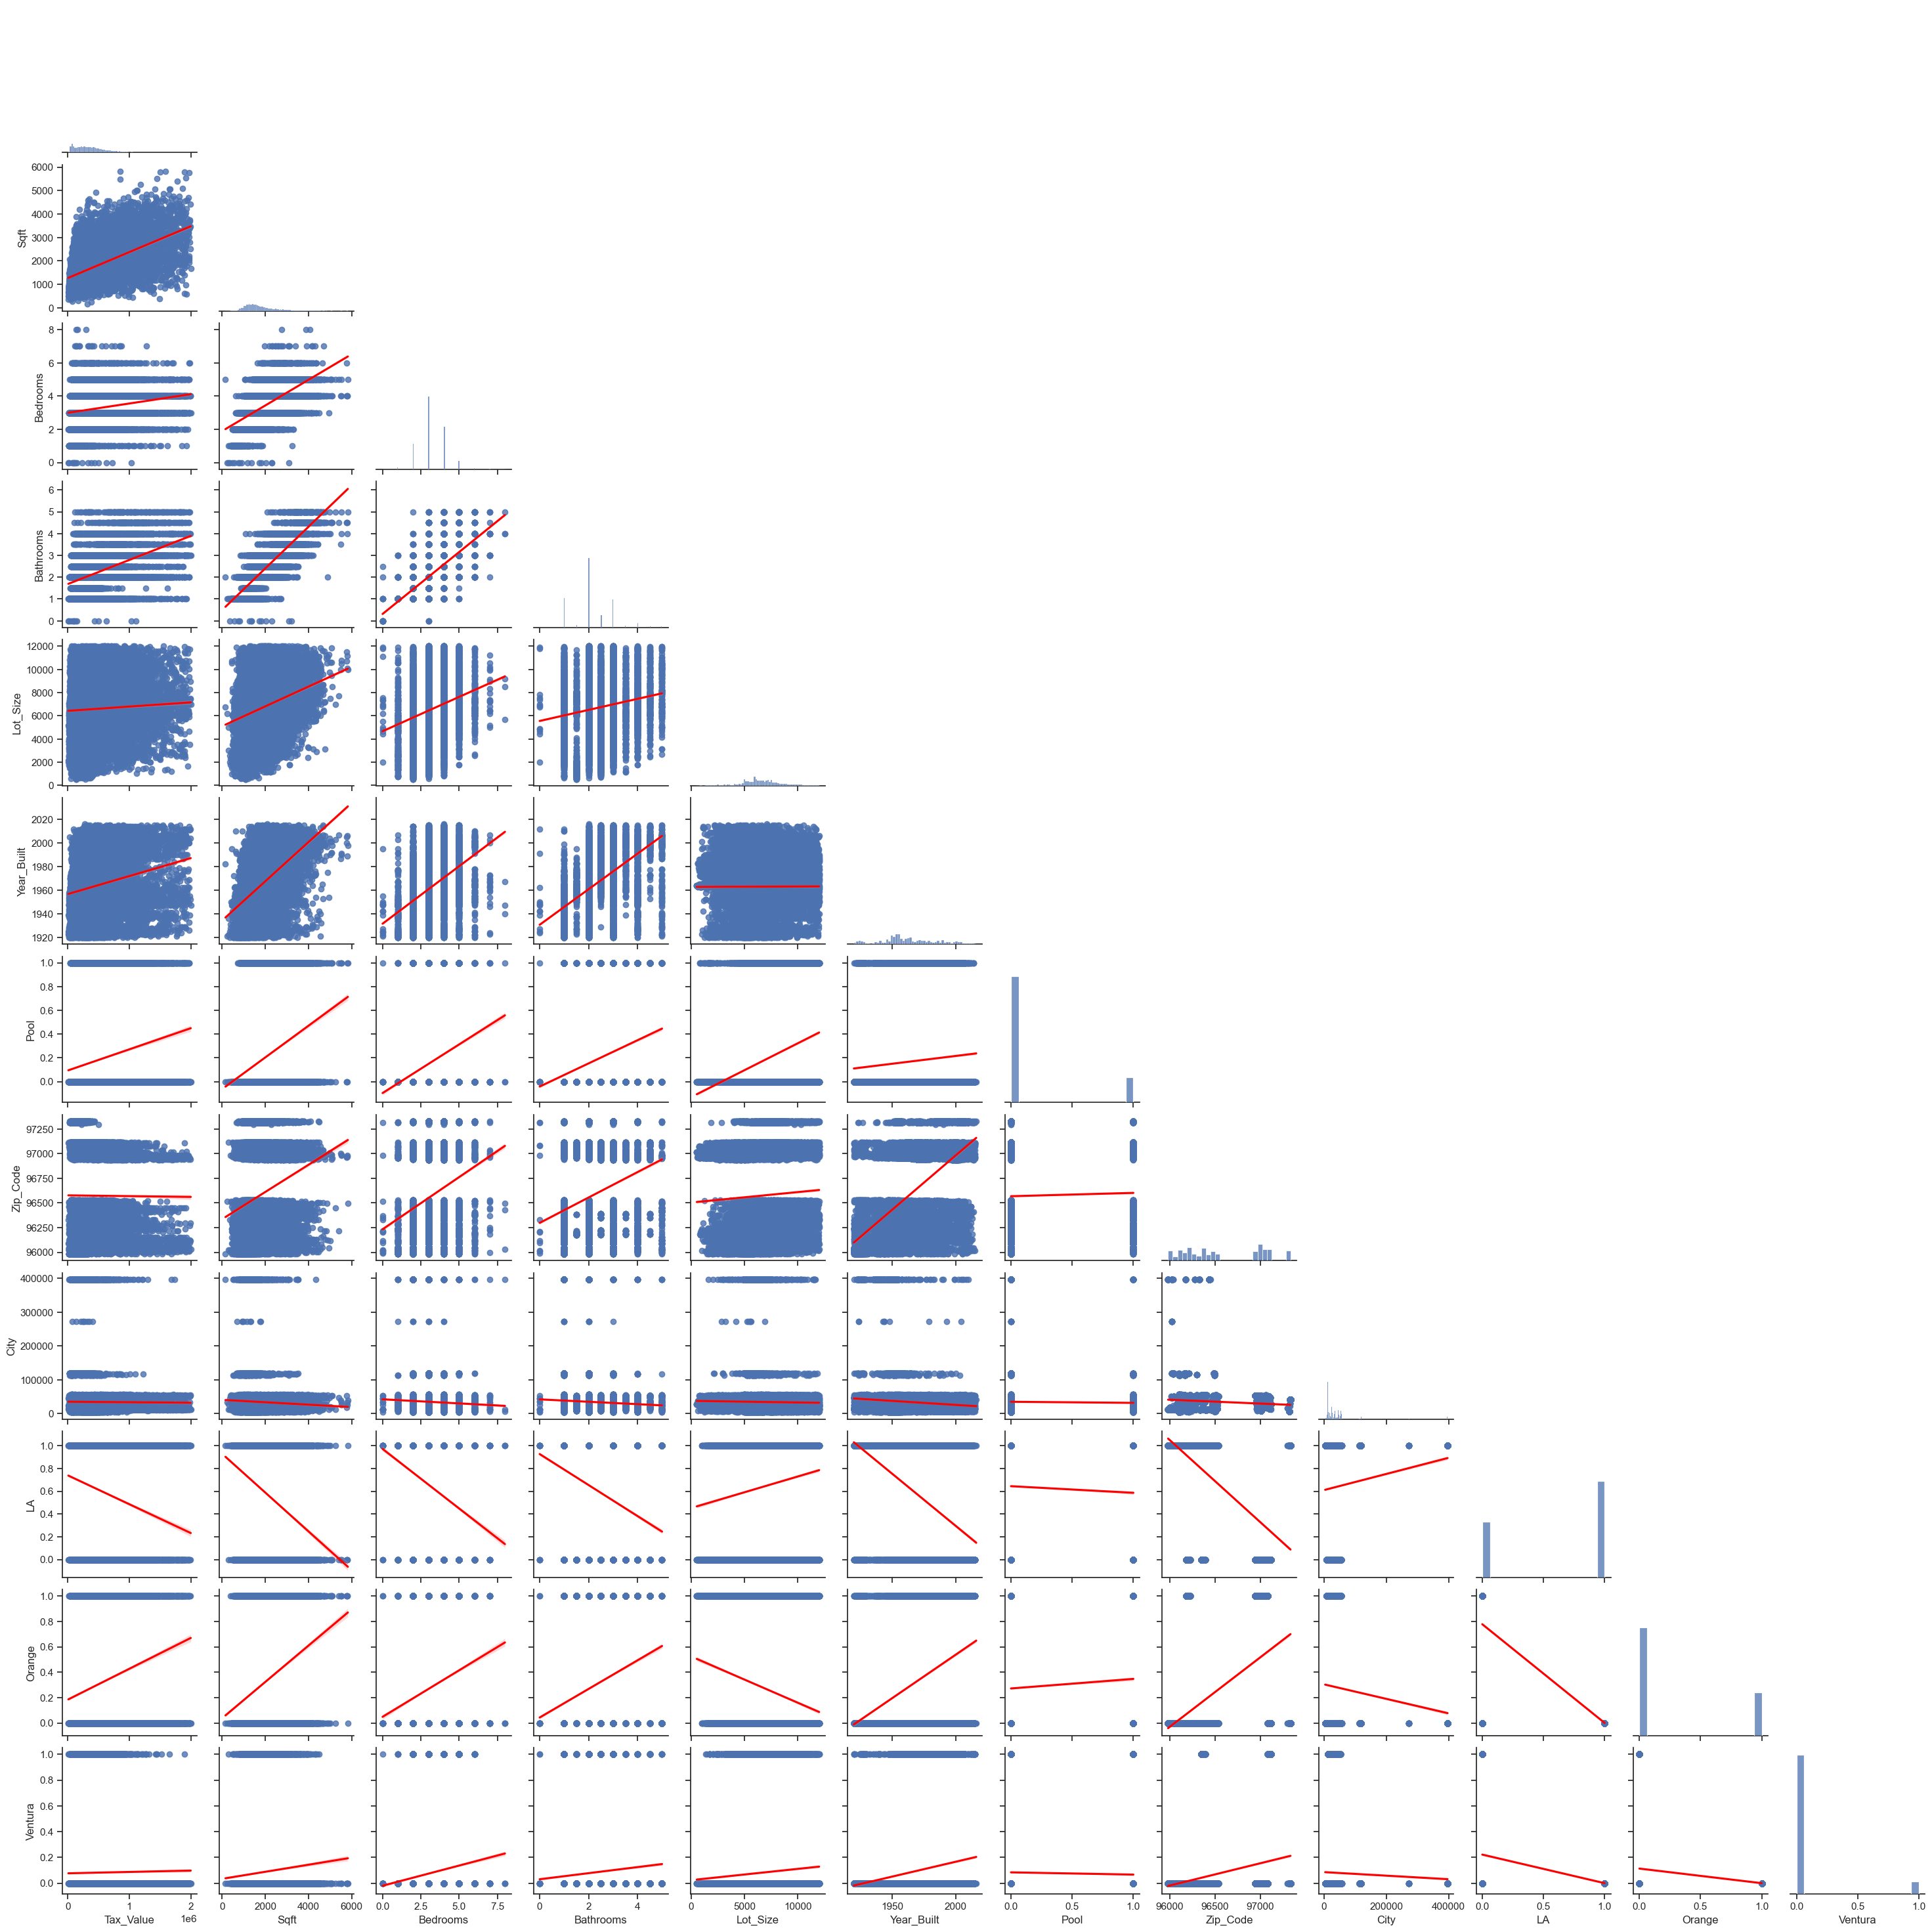

In [36]:
# Visualize pairwise relationships
e.plot_variable_pairs(train)

# Relationship between Sqft and Tax_Value
 $H_{0}$ Sqft does not influence price.
    
 $H_{a}$ Sqft does influence price.

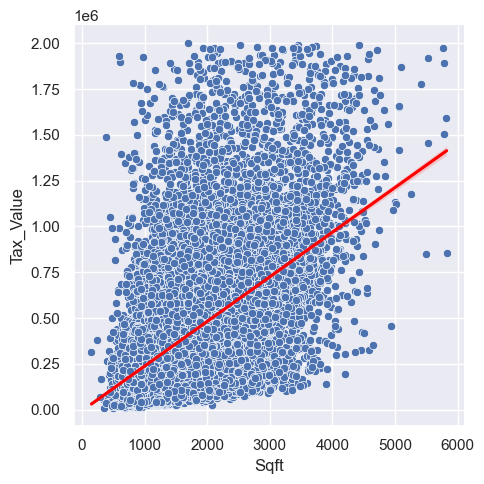

In [37]:
#Visualize Sqft and Tax_Value
sns.set(style="darkgrid")

# Create a scatter plot with regression line
sns.relplot(x="Sqft", y="Tax_Value", data=train, kind="scatter")
sns.regplot(x="Sqft", y="Tax_Value", data=train, scatter=False, color='red')

# Show the plot
plt.show()

#### Stats test
- Run stats test to confirm/or contradict Hypothesis statement

In [ ]:
# run pearsonr test because they are both continuous variables with a normal distribution
r,p = pearsonr(train.Sqft, train.Tax_Value)
r,p

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Sqft does affect Tax_Value

# Relationship between Lot_Size and Tax_Value
 $H_{0}$ Lot_Size does not influence price.
    
 $H_{a}$ Lot_Size does influence price.

In [ ]:
# Visualize lot size (normal distribution)
sns.histplot(train.Lot_Size)
plt.show()

In [ ]:
#Visualize Sqft and Tax_Value
sns.set(style="darkgrid")

# Create a scatter plot with regression line
sns.relplot(x="Lot_Size", y="Tax_Value", data=train, kind="scatter")
sns.regplot(x="Lot_Size", y="Tax_Value", data=train, scatter=False, color='red')

# Show the plot
plt.show()

#### Stats test
- Run stats test to confirm Hypothesis

In [ ]:
r, p = pearsonr(train.Sqft, train.Tax_Value)
print(f"p-value: {p:.10e}")

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Lot_Size does affect Tax_Value

# Relationship between Tax_Value (continuous) and County (categorical)
 $H_{0}$ Location does not affect price.
    
 $H_{a}$ Location does affect price.

In [ ]:
# Use function graph categorical and continuous variables
e.plot_categorical_and_continuous_vars(train, 'County', 'Tax_Value')

### prepare data for ANOVA stats test

In [ ]:
# set three separate categories to Tax_Value and compare them
la = train[train.County == 'LA'].Tax_Value
orange = train[train.County == 'Orange'].Tax_Value
ventura = train[train.County == 'Ventura'].Tax_Value

# run the ANOVA test
tstat, pval = stats.f_oneway(la, orange, ventura)
tstat, pval

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that County location does affect Tax_Value

### Tax_Value (continuous) and Bedrooms (categorical)


 $H_{0}$ Number of Bedrooms does not affect price.
    
 $H_{a}$ Number of Bedrooms does affect price.

In [ ]:
# Use function graph categorical and continuous variables
e.plot_categorical_and_continuous_vars(train, 'Bedrooms', 'Tax_Value')

#### Stats test
- Run stats test to confirm Hypothesis

In [ ]:
# check if variances are equal
stats.levene(train.Bedrooms, train.Tax_Value)

In [ ]:
# run stats test
tstat, pval = stats.ttest_ind(train.Bedrooms, train.Tax_Value)
tstat, pval

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Bedrooms do affect Tax_Value

### Tax_Value (continuous) and Bathrooms (categorical)
 $H_{0}$ Number of Bathrooms does not affect price.
    
 $H_{a}$ Number of Bathrooms does affect price.

In [ ]:
# Use function graph categorical and continuous variables
e.plot_categorical_and_continuous_vars(train, 'Bathrooms', 'Tax_Value')

#### Stats test
- Run stats test to confirm Hypothesis

In [ ]:
# check if variances are equal
stats.levene(train.Bedrooms, train.Tax_Value)

In [ ]:
# run stats test
tstat, pval = stats.ttest_ind(train.Bathrooms, train.Tax_Value)
tstat, pval

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that Bathroom do affect Tax_Value

### Tax_Value (continuous) and Pool (categorical)
 $H_{0}$ Having a pool does not affect price.
    
 $H_{a}$ Having a pool does affect price.

In [ ]:
# Use function graph categorical and continuous variables
e.plot_categorical_and_continuous_vars(train, 'Pool', 'Tax_Value')

#### Stats test
- Run stats test to confirm Hypothesis

In [ ]:
# check for equal variance
stats.levene(train.Pool, train.Tax_Value)

In [ ]:
# run the stats test
tstat, pval = stats.ttest_ind(train.Pool, train.Tax_Value)
tstat, pval

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that have a Pool does affect Tax_Value

### Tax_Value (continuous) and Year_Built (continuous)
 $H_{0}$ Year_Built does not affect price.
    
 $H_{a}$ Year_Built does affect price.

In [ ]:
#Visualize Sqft and Tax_Value
sns.set(style="darkgrid")

# Create a scatter plot with regression line
sns.relplot(x="Year_Built", y="Tax_Value", data=train, kind="scatter")
sns.regplot(x="Year_Built", y="Tax_Value", data=train, scatter=False, color='red')

# Show the plot
plt.show()

#### Stats test
- Run stats test to confirm Hypothesis

In [ ]:
# run stats test
r, p = pearsonr(train.Sqft, train.Tax_Value)
print(f"p-value: {p:.10e}")

- Stats test confirms there is a relationship therefore we reject the null hypothesis and can infer that have a Year_Built does affect Tax_Value

### Tax_Value (continuous) and Zip_Code (categorical)
 $H_{0}$ Zip_Code does not affect price.
    
 $H_{a}$ Zip_Code does affect price.

### Tax_Value (continuous) and City (categorical)
 $H_{0}$ Zip_Code does not affect price.
    
 $H_{a}$ Zip_Code does affect price.

In [ ]:
# Look at correlations
train.corr()

In [ ]:

# Increase the figure size to accommodate the heatmap
plt.figure(figsize=(10, 8))

# Correlation heat map
sns.heatmap(train.corr(method='pearson'), cmap='PRGn', annot=True, fmt=".2f",
            mask=np.triu(train.corr(method='pearson')))

# Adjust the font size of the annotations
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

# Show the plot
plt.show()


# Exploration Takeaways

- All features are statistically significant to Tax_Value, based on pvalues gained through statistical testing
- This is a second run through, so I will remove all location independent variables. This decision is based on their low correlation to the target.
- Lot size is not correlated, therefore I will not move the variable into modeling. 
- Sqft, Bathrooms, Year_Built, Bedrooms, and Pool are the highest correlated independent variables to the target (Respectively).

# Modeling

In [ ]:
### Set and explore the target (Tax_Value)

In [ ]:
# set baseline
baseline = round(y_train.mean(),2)
baseline

In [ ]:
#visualize baseline
plt.hist(y_train)
plt.xlabel("Value")
plt.ylabel("Number of houses")
plt.title('Distribution of home values')
plt.show()

In [ ]:
#make an array to send into my mean_square_error function
baseline_array = np.repeat(baseline, len(train))
baseline_array

In [ ]:
# Evaluate the baseline rmse and r2
rmse, r2 = eva.metrics_reg(y_train, baseline_array)
rmse, r2

In [ ]:
# add results to a dataframe for comparison
metrics_df = pd.DataFrame(data=[
    {
        'model':'baseline',
        'rmse':rmse,
        'r2':r2
    }
    
])
metrics_df

In [ ]:
# OLS - Ordinary Least Squares
# Multiple Regression
- also using Recursive Feature Eliminations

In [ ]:
# Run regression through all possible combinations. Select and graph best model.
eva.run_regression1(X_train_scaled, y_train) 